In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#!ls /content/gdrive

Mounted at /content/drive


In [2]:
# configuration
path = "/content/drive/MyDrive/Colab Notebooks/Project_REScipe/training/"

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from scipy.spatial.distance import cosine

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import PIL
from PIL import Image

if torch.cuda.is_available():
  print(torch.cuda.is_available())
  torch.set_default_tensor_type(torch.cuda.FloatTensor)

True


===================== A =====================

Load train and valid dataset from pickle files into panda dataframe.

In [4]:
# training resnet
pd.set_option('display.max_columns', None)

t0 = pd.read_pickle(path + "resnet34_train_dataframe0.plk")
print('# images in df0:', len(t0))
t1 = pd.read_pickle(path + "resnet34_train_dataframe1.plk")
print('# images in df1:', len(t1))
t2 = pd.read_pickle(path + "resnet34_train_dataframe2.plk")
print('# images in df2:', len(t2))
t3 = pd.read_pickle(path + "resnet34_train_dataframe3.plk")
print('# images in df3:', len(t3), end='\n\n')

train_dataframe = pd.concat([t0,t1,t2,t3], ignore_index=True)
train_dataframe = train_dataframe.drop(columns=['code'])
print('dataframe shape:', train_dataframe.shape, end='\n\n')

print('MLP input shape:', (train_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (train_dataframe.iloc[0][1]).shape)

# images in df0: 50000
# images in df1: 50000
# images in df2: 50000
# images in df3: 50000

dataframe shape: (200000, 2)

MLP input shape: (1, 4608)
MLP output shape: (300,)


In [5]:
# validation resnet
v0 = pd.read_pickle(path + "resnet34_val_dataframe0.plk")
print('# images in df0:', len(v0))
v1 = pd.read_pickle(path + "resnet34_val_dataframe1.plk")
print('# images in df1:', len(v1))
v2 = pd.read_pickle(path + "resnet34_val_dataframe2.plk")
print('# images in df2:', len(v2))
v3 = pd.read_pickle(path + "resnet34_val_dataframe3.plk")
print('# images in df3:', len(v3))

valid_dataframe = pd.concat([v0,v1,v2,v3], ignore_index=True)
valid_dataframe = valid_dataframe.drop(columns=['code'])
print('dataframe shape:', valid_dataframe.shape, end='\n\n')

print('MLP input shape:', (valid_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (valid_dataframe.iloc[0][1]).shape)

# images in df0: 10000
# images in df1: 10000
# images in df2: 10000
# images in df3: 10000
dataframe shape: (40000, 2)

MLP input shape: (1, 4608)
MLP output shape: (300,)


===================== B =====================

Check similarity between MLP inputs from outputs of Resnet.

In [7]:
## This doesn't work, it assume we have 300 distinct labels but apparently that isnt the case
# print(len(valid_dataframe["label"].values))
# label_classes = []
# def arreqclose_in_list(myarr, list_arrays):
#     return next((True for elem in list_arrays if elem.size == myarr.size and np.allclose(elem, myarr)), False)

# for i in range(len(valid_dataframe["label"].values)):
#   check = arreqclose_in_list(valid_dataframe["label"].values[i], label_classes)
#   if not(check):
#     label_classes.append(valid_dataframe["label"].values[i])
#     print(i,len(label_classes))
#   if i % 1000 == 0:
#     print(i)

## Cosine Similarity Test for first two set of similar images (5 images in each set)
print(valid_dataframe.columns, end='\n\n')
print('cos_similarity', 'e_distance', 'index (cmp with next)', sep='\t')
for i in range(10):
  point1 = valid_dataframe["resnet34_features"].values[i]
  point2 = valid_dataframe["resnet34_features"].values[i+1]
  sim = cosine_similarity(point1,point2)
  dist = np.linalg.norm(point1 - point2) 
  print(sim, dist, i, sep='\t')

Index(['resnet34_features', 'label'], dtype='object')

cos_similarity	e_distance	index (cmp with next)
[[0.72970814]]	146.37485	0
[[0.7075788]]	154.25348	1
[[0.6919104]]	160.12764	2
[[0.74733424]]	146.80194	3
[[0.75126433]]	144.9557	4
[[0.7529588]]	142.30232	5
[[0.7623331]]	136.33939	6
[[0.7704773]]	135.83604	7
[[0.75061285]]	144.2332	8
[[0.75768054]]	142.24525	9


===================== C =====================

Load test dataset from pickle files into panda dataframe.

In [8]:
t = pd.read_pickle(path + "resnet34_test_dataframe.plk")
#print('# images in df:', len(t))
#print(t, end='\n')

test_dataframe = pd.concat([t], ignore_index=True)
test_dataframe = test_dataframe.drop(columns=['code'])
print('dataframe shape:', test_dataframe.shape, end='\n\n')

print('MLP input shape:', (test_dataframe.iloc[0][0]).shape)
print('MLP output shape:', (test_dataframe.iloc[0][1]).shape)

dataframe shape: (9090, 2)

MLP input shape: (1, 4608)
MLP output shape: (300,)


===================== C-Addition =====================

Visualizing data distribution.

In [9]:
train_pd = pd.concat([t0, t1, t2, t3], ignore_index=True)
print('# images in training set:', len(train_pd))
print(train_pd, end='\n\n\n')
valid_pd = pd.concat([v0, v1, v2, v3], ignore_index=True)
print('# images in validation set:', len(valid_pd))
print(valid_pd, end='\n\n\n')
test_pd = pd.concat([t], ignore_index=True)
print('# images in testing set:', len(test_pd))
print(test_pd)

# images in training set: 200000
                                        resnet34_features  \
0       [[5.66533, 3.9584274, 2.8474789, 2.088553, 0.0...   
1       [[2.4422185, 0.720664, 2.3695743, 2.4422185, 2...   
2       [[6.4415007, 2.5519738, 0.47227764, 2.74739, 0...   
3       [[2.3219042, 2.2289014, 4.2227426, 2.3219042, ...   
4       [[7.378936, 1.1541784, 0.08567299, 4.1207137, ...   
...                                                   ...   
199995  [[4.0673866, 4.349452, 2.9622204, 5.951891, 5....   
199996  [[4.282581, 4.282581, 1.6701305, 5.5788774, 5....   
199997  [[4.279215, 4.279215, 0.9419547, 5.8161125, 5....   
199998  [[4.349249, 4.349249, 2.7728372, 5.2194777, 5....   
199999  [[2.1386952, 2.1386952, 1.2854693, 4.4147453, ...   

                                                    label    code  
0       [0.001109877913429523, 0.001109877913429523, 0...   70006  
1       [0.001109877913429523, 0.001109877913429523, 0...   70006  
2       [0.001109877913429523,

===================== D =====================

Define PyTorch dataset with this dataset.

In [10]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    X = self.X[index]
    y = self.y[index]
    return X,y

===================== E =====================

Other helper functions:

(1) printing plots

(2) evaluating model

(3) accuracy function

In [11]:
# printing plot
def plot_result(x=None, y=[], title=[], x_axis="", y_axis="", plot_title=""):
  plt.figure()
  i = 0
  for accu in y:
    plt.plot(x, accu, label=title[i])
    i += 1
  plt.legend(loc='best')
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title(plot_title)
  plt.ylim(0)
  plt.show()

# evaluating a model (model, loss function, valid/test dataloader)
def evaluate(model, loss_fnc, val_iter):
  model.eval()

  running_loss = 0.0
  running_correct = 0.0
  count = 0.0
  for data in val_iter:
    X, y = data
    ## ===================== CUDA version
    # For Resnet:
    X = torch.squeeze(X,1)
    X = X.type(torch.cuda.FloatTensor)
    y = y.type(torch.cuda.FloatTensor)
    ## =====================
    output = model(X)
    loss = loss_fnc(output, y)
    running_loss += loss.item() * len(y)
    running_correct += accurate(output, y)
    count += len(y)
  return running_correct/count, running_loss/count

# accuracy function: return number of "correct" prediction
def accurate(pred, label):
  correct = 0
  for i in range(pred.shape[0]): # get the length, maybe use len
    f = pred[i].cpu().detach().numpy().reshape(1,-1)
    l = label[i].cpu().detach().numpy().reshape(1,-1)
    similarity = cosine_similarity(f,l)
    if similarity > 0.9:
      correct += 1
  return correct

===================== F =====================

Resnet MLP model and training setup (hyperparameters):

In [19]:
# resnet34 model
class RES34MLP(nn.Module):
  def __init__(self):
    super(RES34MLP, self).__init__()
    # in-size 4608
    self.bn0 = nn.BatchNorm1d(4608)
    self.fc1 = nn.Linear(4608, 1024)
    self.bn1 = nn.BatchNorm1d(1024)
    self.rl1 = nn.LeakyReLU()
    self.drop1 = nn.Dropout(0.15)
    # semantic output 1024
    self.fc2 = nn.Linear(1024, 1000)
    self.bn2 = nn.BatchNorm1d(1000)
    self.rl2 = nn.LeakyReLU()
    self.drop2 = nn.Dropout(0.1)
    # output size 300
    self.fc3 = nn.Linear(1000, 300)
    self.rl3 = nn.LeakyReLU()

  def forward(self, features):
    # (4608, 1024)
    x = self.bn0(features)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.rl1(x)
    x = self.drop1(x)
    # (1024, 1000)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.rl2(x)
    x = self.drop2(x)
    # to be removed (1000, 300)
    x = self.fc3(x)
    x = self.rl3(x)
    return x


# hyperparameters (the same as baseline)
batch_size = 128
learning_rate = 0.001
E = 120

# model setup
model = RES34MLP()
# model = torch.load('/content/drive/MyDrive/Colab Notebooks/Project_REScipe/training/models/res_model_decode_42.pt')
loss_fnc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# data setup
train_set = Dataset(train_dataframe['resnet34_features'].values, train_dataframe['label'].values)
valid_set = Dataset(valid_dataframe['resnet34_features'].values, valid_dataframe['label'].values)
test_set = Dataset(test_dataframe['resnet34_features'].values, test_dataframe['label'].values)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)


# use as applicable
#if torch.cuda.is_available(): 
model.cuda()
#"""""""""""""""""CHANGE"""""""""""""""""
# change in the training loop if need to convert to cuda


RES34MLP(
  (bn0): BatchNorm1d(4608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1000, bias=True)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=1000, out_features=300, bias=True)
  (rl3): LeakyReLU(negative_slope=0.01)
)

100%|██████████| 1563/1563 [01:22<00:00, 18.92it/s]


[  1] train loss: 0.00905 train accu: 0.000060 valid loss: 0.008798 valid accu: 0.000225


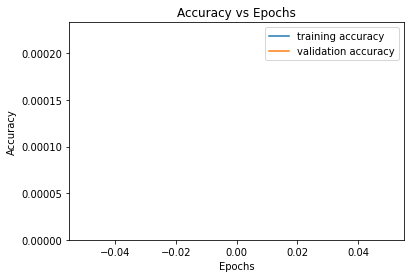

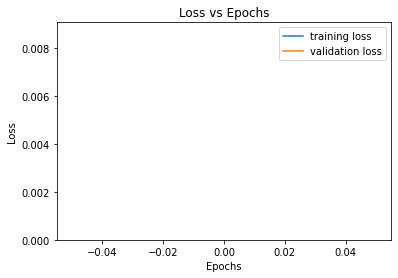

  0%|          | 0/1563 [00:00<?, ?it/s]

[  2] train loss: 0.00872 train accu: 0.000195 valid loss: 0.008550 valid accu: 0.000000


  0%|          | 0/1563 [00:00<?, ?it/s]

[  3] train loss: 0.00849 train accu: 0.000000 valid loss: 0.008438 valid accu: 0.000000


  0%|          | 0/1563 [00:00<?, ?it/s]

[  4] train loss: 0.00840 train accu: 0.000275 valid loss: 0.008316 valid accu: 0.000650


  0%|          | 0/1563 [00:00<?, ?it/s]

[  5] train loss: 0.00821 train accu: 0.002705 valid loss: 0.008105 valid accu: 0.005125


100%|██████████| 1563/1563 [01:21<00:00, 19.24it/s]


[  6] train loss: 0.00789 train accu: 0.010240 valid loss: 0.007902 valid accu: 0.010350


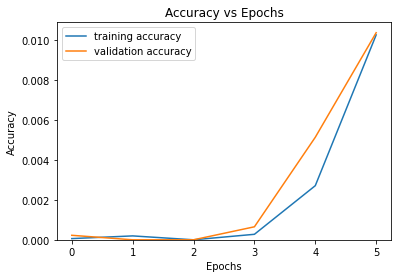

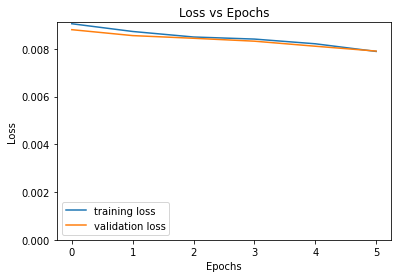

  0%|          | 0/1563 [00:00<?, ?it/s]

[  7] train loss: 0.00752 train accu: 0.022440 valid loss: 0.007705 valid accu: 0.020925


  0%|          | 0/1563 [00:00<?, ?it/s]

[  8] train loss: 0.00717 train accu: 0.037780 valid loss: 0.007534 valid accu: 0.029175


  0%|          | 0/1563 [00:00<?, ?it/s]

[  9] train loss: 0.00686 train accu: 0.052595 valid loss: 0.007426 valid accu: 0.034300


  0%|          | 0/1563 [00:00<?, ?it/s]

[ 10] train loss: 0.00661 train accu: 0.065475 valid loss: 0.007321 valid accu: 0.039025


100%|██████████| 1563/1563 [01:21<00:00, 19.21it/s]


[ 11] train loss: 0.00640 train accu: 0.076610 valid loss: 0.007241 valid accu: 0.043500


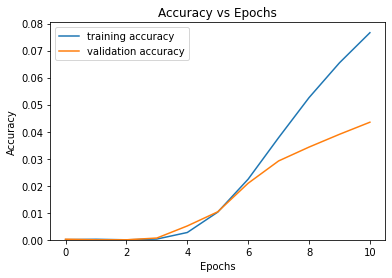

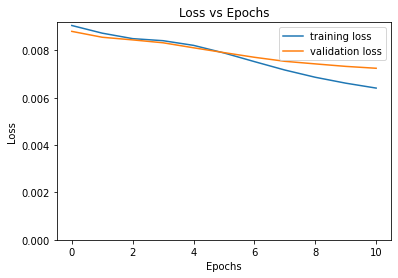

  0%|          | 0/1563 [00:00<?, ?it/s]

[ 12] train loss: 0.00623 train accu: 0.087055 valid loss: 0.007187 valid accu: 0.047350


  0%|          | 0/1563 [00:00<?, ?it/s]

[ 13] train loss: 0.00608 train accu: 0.096935 valid loss: 0.007137 valid accu: 0.047725


 24%|██▍       | 377/1563 [00:19<01:00, 19.53it/s]

In [ ]:
torch.manual_seed(0)
from tqdm import tqdm
from copy import deepcopy

# training loop
epochs = []
trainAccu = []
trainLoss = []
validAccu = []
validLoss = []

for epoch in range(0, E, 1):
  running_loss = 0.0
  running_correct = 0.0
  count = 0.0

  model.train()

  for i, data in enumerate(tqdm(train_loader, position=0)):
    # organize data
    X, y = data

    X = torch.squeeze(X,1)
    X = X.type(torch.cuda.FloatTensor)
    y = y.type(torch.cuda.FloatTensor)
    # """""""""""""""""CHANGE""""""""""""""""" IF CUDA
    
    # train
    optimizer.zero_grad()

    output = model(X)

    loss = loss_fnc(output, y)
    loss.backward()

    optimizer.step()

    # test
    running_loss += loss.item()*len(y)
    #print(output.cpu().detach().numpy().shape)
    #print(y.cpu().detach().numpy().shape)
    running_correct += accurate(output, y)
    count += len(y)
  
  # evaluate at every epoch
  trainAccu.append(running_correct/count)
  trainLoss.append(running_loss/count)
  epochs.append(epoch)

  # evaluate validation accuracy
  correct, loss = evaluate(model, loss_fnc, valid_loader)

  validAccu.append(correct)
  validLoss.append(loss)

  print("[%3d] train loss: %.5f train accu: %f valid loss: %f valid accu: %f" % (epoch+1, trainLoss[-1], trainAccu[-1], validLoss[-1], validAccu[-1]))

  # save at every epoch if needed
  torch.save(model, path + 'models/res34_model_base_' + str(epoch) + '.pt')

  if epoch % 5 == 0:
    plot_result(x=deepcopy(epochs), y=[deepcopy(trainAccu), deepcopy(validAccu)], title=["training accuracy", "validation accuracy"], x_axis="Epochs", y_axis="Accuracy", plot_title="Accuracy vs Epochs")
    plot_result(x=deepcopy(epochs), y=[deepcopy(trainLoss), deepcopy(validLoss)], title=["training loss", "validation loss"], x_axis="Epochs", y_axis="Loss", plot_title="Loss vs Epochs")


# visualize result
plot_result(x=epochs, y=[trainAccu, validAccu], title=["training accuracy", "validation accuracy"], x_axis="Epochs", y_axis="Accuracy", plot_title="Accuracy vs Epochs")
plot_result(x=epochs, y=[trainLoss, validLoss], title=["training loss", "validation loss"], x_axis="Epochs", y_axis="Loss", plot_title="Loss vs Epochs")
print("Test accuracy and loss: ", evaluate(model, loss_fnc, test_loader))

torch.save(model, path + 'models/res34_model_base_last.pt')
